In [1]:
import sys, os, pygmt, importlib, re, time
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate    import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
import numpy              as np
import pandas             as pd
import xarray             as xr
import xesmf              as xe
import matplotlib.pyplot  as plt
import matplotlib.dates   as mdates
import matplotlib.animation as animation

In [105]:
import sys
import importlib
# Step 1: Clear all relevant modules
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
# Step 2: Explicit reloads in dependency order
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
importlib.reload(pygmt)
# Step 3: Re-import key class from module (to refresh the class definition)
from sea_ice_toolbox import SeaIceToolbox

In [ ]:
# G_CMEMS  = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p25_grid.nc").rename_dims({'x':'longitude','y':'latitude'})
# CMEMS_SI = xr.open_mfdataset("/g/data/gv90/da1339/SeaIce/CMEMS/0p25/daily/199*_CMEMS_org.nc")
# G_CMEMS_SO = G_CMEMS.isel(latitude=slice(0,340))
# CMEMS_SI_SO = CMEMS_SI.isel(latitude=slice(0,340))
# print(G_CMEMS_SO)
# print(CMEMS_SI_SO)
OSI_SAF = xr.open_mfdataset("/g/data/gv90/da1339/SeaIce/OSI_SAF/ice_drift_455m/sh/ice_drift_sh_ease2-750_cdr-v1p0_24h-199*")
print(OSI_SAF)
print(OSI_SAF['Lambert_Azimuthal_Equal_Area'].proj4_string)
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
SI_tools.load_bgrid()
print(SI_tools.G_t.isel(nj=slice(0,540),nj_b=slice(0,541)))

In [ ]:
grid_src = {"lon": OSI_SAF["lon"],
            "lat": OSI_SAF["lat"]}
grid_dst = {"lon": SI_tools.G_t["lon"],
            "lat": SI_tools.G_t["lat"]}
reG      = xe.Regridder(grid_src, grid_dst, method="bilinear", periodic=True, filename="/g/data/gv90/da1339/grids/weights/OSI-SAF_to_AOM2-025_tgrid_bil.nc")

In [ ]:
vars_to_regrid = ['dX', 'dY', 'uncert_dX_and_dY', 'lat1', 'lon1', 'status_flag']
regridded_vars = {}
for var in vars_to_regrid:
    print(f"Regridding: {var}")
    regridded_vars[var]         = xr.concat( [reG(OSI_SAF[var].isel(time=i)) for i in range(OSI_SAF.dims['time'])], dim="time")
    regridded_vars[var]['time'] = OSI_SAF['time']

In [ ]:
dt = (OSI_SAF["time_bnds"].isel(nv=1) - OSI_SAF["time_bnds"].isel(nv=0)) / np.timedelta64(1, 's')  # in seconds
dX = regridded_vars["dX"]   # shape: (time, nj, ni), in meters
dY = regridded_vars["dY"]   # shape: (time, nj, ni), in meters
disp_mag = np.sqrt(dX**2 + dY**2)
dt_broadcast = dt.broadcast_like(disp_mag)
ice_speed = disp_mag / dt_broadcast
ice_speed.name = "ice_speed"
ice_speed.attrs["units"] = "m s-1"
ice_speed.attrs["long_name"] = "Sea ice drift speed"
print(ice_speed)

In [ ]:
years = range(1993, 2000)
ice_speed_yearly = {}
for yr in years:
    ds = ice_speed.sel(time=slice(f"{yr}-01-01", f"{yr}-12-31"))
    ds_chunked = ds.chunk({'time': 30, 'nj': 540, 'ni': 1440}).compute()
    ds_chunked.to_netcdf(f"/g/data/gv90/da1339/SeaIce/OSI_SAF/ispd_reG_SH_ice_drift_455m_{yr}.nc")

In [ ]:
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)

DS, CICE    = SI_tools.load_processed_cice(zarr_CICE = True)
CICE_SO     = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
sim_name    = "AOM2-ERA5"
dt0_str     = "1993-01-01"
dtN_str     = "1999-12-31"
SI_tools    = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
DS, AOM2    = SI_tools.load_processed_cice(zarr_CICE = True)
AOM2_SO     = AOM2.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
OSI_SAF     = xr.open_mfdataset("/home/581/da1339/seaice/OSI_SAF/ispd_reG_SH*")

In [ ]:
AOM2_ispd   = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid(AOM2, ivec_type = 'BT')
CICE_ispd   = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid(CICE, ivec_type = 'BT')

In [ ]:
da_obs      = OSI_SAF.isel(nj=slice(0,540)).ice_speed
da_cice     = CICE.isel(nj=slice(0,540)).ispd_BT
da_aom2     = AOM2.isel(nj=slice(0,540)).ispd_BT
da_cice['time'] = pd.to_datetime(da_cice.time.values).normalize()
da_aom2['time'] = pd.to_datetime(da_aom2.time.values).normalize()
da_obs['time']  = pd.to_datetime(da_obs.time.values).normalize()
t_common = np.intersect1d(da_cice.time.values, da_obs.time.values)
t_common = np.intersect1d(t_common, da_aom2.time.values)
da_cice = da_cice.sel(time=t_common)
da_aom2 = da_aom2.sel(time=t_common)
da_obs  = da_obs.sel(time=t_common)
print(da_cice.time.values[:5])
print(da_aom2.time.values[:5])
print(da_obs.time.values[:5])

In [47]:
print(da_obs.min().values)
print(da_obs.max().values)

0.0


In [38]:
def compute_taylor_stats_streaming(da1, da2, chunk_size=30):
    """
    Compute Taylor stats between two large 3D Dask-backed arrays
    by chunking along time.
    """
    assert da1.shape == da2.shape
    assert da1.dims == da2.dims

    all_model = []
    all_obs   = []

    for i in range(0, da1.sizes['time'], chunk_size):
        # Safely slice a time chunk
        chunk1 = da1.isel(time=slice(i, i+chunk_size)).compute()
        chunk2 = da2.isel(time=slice(i, i+chunk_size)).compute()

        # Flatten and filter valid
        a = chunk1.values.flatten()
        b = chunk2.values.flatten()
        valid = np.isfinite(a) & np.isfinite(b)

        if valid.sum() == 0:
            continue

        all_model.append(a[valid])
        all_obs.append(b[valid])

    # Concatenate all valid values
    model = np.concatenate(all_model)
    obs   = np.concatenate(all_obs)

    if model.size == 0:
        raise ValueError("No overlapping valid data between the two datasets.")

    corr = np.corrcoef(model, obs)[0, 1]
    std_model = np.std(model)
    std_obs   = np.std(obs)
    rmsd = np.sqrt(np.mean((model - obs - (np.mean(model) - np.mean(obs)))**2))

    return {
        "corr": corr,
        "std_model": std_model,
        "std_obs": std_obs,
        "std_ratio": std_model / std_obs,
        "rmsd": rmsd,
        "rmsd_norm": rmsd / std_obs
    }

In [39]:
stats_cice_obs  = compute_taylor_stats_streaming(da_cice, da_obs)
stats_aom2_obs  = compute_taylor_stats_streaming(da_aom2, da_obs)
stats_cice_aom2 = compute_taylor_stats_streaming(da_cice, da_aom2)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 132.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/cl

In [40]:
def plot_taylor(stats_dict, out_path):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(-1)

    for rms in [0.2, 0.5, 1.0, 1.5]:
        rs = np.linspace(0.5, 2.0, 500)
        theta = np.arccos(np.clip(1 - (rms**2 - 1)/(2 * rs), -1, 1))
        ax.plot(theta, rs, '--', color='gray', lw=0.6)
    ax.plot([0], [1], 'ko', label='Reference')

    for label, stat in stats_dict.items():
        angle = np.arccos(stat["corr"])
        r = stat["std_ratio"]
        ax.plot(angle, r, 'o', label=label)

    ax.set_rmax(2)
    ax.set_rticks([0.5, 1.0, 1.5, 2.0])
    ax.set_rlabel_position(135)
    ax.set_title("Taylor Diagram: Sea Ice Speed Comparison", fontsize=12)
    ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.1))
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

In [42]:
stats_cice_obs

{'corr': 0.8948484480130919,
 'std_model': 0.05573553,
 'std_obs': 6.157805558673686e-05,
 'std_ratio': 905.1199804543752,
 'rmsd': 0.055689905401475864,
 'rmsd_norm': 904.3790823020202}

In [43]:
plot_taylor(
    {"CICE vs OSI-SAF": stats_cice_obs},
    os.path.join("/g/data/gv90/da1339/GRAPHICAL/AFIM/taylor_diagram", "elps-min_taylor_diagram_seaice_speed.png")
)

In [44]:
da_obs = da_obs * 1000  # e.g. convert cm/s → m/s if needed
da_o

In [21]:
stats = {"CICE vs OSI-SAF": compute_taylor_stats(cice_vals, obs_vals),
         "AOM2 vs OSI-SAF": compute_taylor_stats(aom2_vals, obs_vals),
         "CICE vs AOM2"   : compute_taylor_stats(cice_vals, aom2_vals)}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/g/data/xp6

In [22]:
def plot_taylor(stats_dict):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)

    ax.set_theta_zero_location('E')
    ax.set_theta_direction(-1)

    # Grid for contours
    stds = np.linspace(0, 2, 100)
    angles = np.arccos(np.linspace(0, 1, 100))
    for rms in [0.2, 0.5, 1.0, 1.5]:
        rs = np.linspace(0, 2, 500)
        theta = np.arccos(np.clip(1 - (rms**2 - 1) / (2 * rs), -1, 1))
        ax.plot(theta, rs, ls='--', color='gray', lw=0.7)

    # Add reference point at (1, 0°)
    ax.plot([0], [1], 'ko', label='Reference')

    # Plot each dataset
    for label, (corr, std_ratio, rmsd_ratio) in stats_dict.items():
        angle = np.arccos(corr)
        ax.plot(angle, std_ratio, 'o', label=label)

    ax.set_rmax(2)
    ax.set_rticks([0.5, 1.0, 1.5, 2.0])
    ax.set_rlabel_position(135)
    ax.set_title("Taylor Diagram: Sea Ice Speed Comparison", fontsize=12)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1))
    plt.tight_layout()
    plt.show()

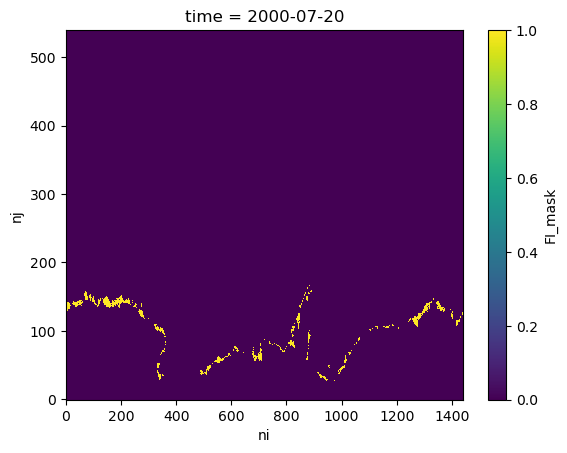

In [104]:
DS['FI_mask'].isel(time=200).plot()

In [ ]:
G_CMEMS     = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p083_grid.nc")#.rename_dims({'longitude':'lon','latitude':'lat'})
CMEMS_SI    = xr.open_mfdataset("/g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/199*_CMEMS*_org.nc",combine='by_coords', chunks={'time': 1})
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
SI_tools.load_bgrid()
grid_src = {"lon": G_CMEMS["longitude"],
            "lat": G_CMEMS["latitude"]}
grid_dst = {"lon": SI_tools.G_t["lon"],
            "lat": SI_tools.G_t["lat"]}
reG      = xe.Regridder(grid_src, grid_dst, method="bilinear", periodic=True, reuse_weights=True, weights="/g/data/gv90/da1339/grids/weights/CMEMS-ORAS-0p083_to_AOM2-025_tgrid_bil.nc")


# Optional: Initialize local Dask cluster
# cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit='4GB')
# client = Client(cluster)
outpath = "/g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/reG_CMEMS-ORAS-SI_1993-1999.zarr"
variables = ['siconc', 'sithick', 'usi', 'vsi']
batch_size = 15
n_time = CMEMS_SI.sizes["time"]
n_batches = n_time // batch_size + (1 if n_time % batch_size else 0)
print(f"Processing {n_time} timesteps in {n_batches} batches of size {batch_size}")
for i in range(n_batches):
    t_loop_start = time.time()
    t0 = i * batch_size
    t1 = min(t0 + batch_size, n_time)
    times = CMEMS_SI.isel(time=slice(t0, t1)).time.values
    print(f"\nBatch {i+1}/{n_batches}: Regridding time {t0}:{t1} ({times[0]} to {times[-1]})")
    regridded_vars = {}
    for var in variables:
        t_var_start = time.time()
        print(f"  Regridding {var}... ", end="")
        sliced = CMEMS_SI[var].isel(time=slice(t0, t1)).load()
        regridded = reG(sliced)  # expects shape (time, nj, ni)
        regridded["time"] = times
        regridded_vars[var] = regridded
        print(f"{time.time() - t_var_start:.2f}s")
    usi, vsi = regridded_vars["usi"], regridded_vars["vsi"]
    ispd = (usi ** 2 + vsi ** 2) ** 0.5
    ispd["time"] = times
    ispd.attrs = {"long_name": "ice speed", "units": "m/s"}
    regridded_vars["ispd"] = ispd
    ds_out = xr.Dataset(regridded_vars).chunk({"time": batch_size})
    print("  Writing to Zarr... ", end="")
    t_write_start = time.time()
    with ProgressBar():
        if i == 0:
            ds_out.to_zarr(outpath, mode='w', consolidated=False)
        else:
            ds_out.to_zarr(outpath, mode='a', append_dim='time', consolidated=False)
    print(f"{time.time() - t_write_start:.2f}s")
    print(f"Batch {i+1} complete in {time.time() - t_loop_start:.2f}s")
print("✅ All batches regridded and saved.")

In [ ]:
reG_oras = xr.open_zarr("/g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/reG_CMEMS-ORAS-SI_1993-1999.zarr")

In [ ]:
sim_name   = "elps-min"
dt0_str    = "2000-01-01"
dtN_str    = "2018-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
DS, CICE    = SI_tools.load_processed_cice(zarr_CICE = True)
FI_obs               = SI_tools.load_AF2020db()
bool_mask            = SI_tools.boolean_fast_ice( DS['FI_mask'] )

In [107]:
CICE_SO              = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
CICE_bool            = CICE_SO.where(bool_mask)
CICE_bool['FI_mask'] = bool_mask
CICE_coar            = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(CICE_bool, FI_obs)
CICE_coar['FI_mask'] = CICE_coar['FI_mask'].astype(bool).astype(int)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/cli

In [108]:
FI_obs_SO     = FI_obs.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
FI_obs_raw    = FI_obs_SO['FI']
FI_sim_raw    = CICE_coar['FI_mask']
FI_obs_bin    = FI_obs_raw.where(FI_obs_raw.notnull()) > 0
FI_sim_bin    = FI_sim_raw.where(FI_sim_raw == 1)             # True/NaN
shared_mask   = (FI_obs_bin == True).any(dim="t_FI_obs") | (FI_sim_bin == True).any(dim="t_FI_obs")
FI_obs_masked = FI_obs_bin.where(shared_mask)
FI_sim_masked = FI_sim_bin.where(shared_mask)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


In [109]:
FIP_obs = SI_tools.compute_variable_aggregate( FI_obs_bin, time_coord_name='t_FI_obs' )
FIP_sim = SI_tools.compute_variable_aggregate( FI_sim_bin, time_coord_name='t_FI_obs' )
shared_mask = (FI_obs_bin == True).any(dim="t_FI_obs") | (FI_sim_bin == True).any(dim="t_FI_obs")
FIP_obs = FIP_obs.where(shared_mask).compute()
FIP_sim = FIP_sim.where(shared_mask).compute()
FIP_obs = FIP_obs.assign_coords({"TLAT": CICE_coar["TLAT"], "TLON": CICE_coar["TLON"]})
FIP_sim = FIP_sim.assign_coords({"TLAT": CICE_coar["TLAT"], "TLON": CICE_coar["TLON"]})

In [53]:
FIP_diff = FIP_obs - FIP_sim
FIP_diff = FIP_diff.where(shared_mask)
FIP_diff

<xarray.DataArray (nj: 540, ni: 1440)> Size: 6MB
dask.array<where, shape=(540, 1440), dtype=float64, chunksize=(68, 180), chunktype=numpy.ndarray>
Coordinates:
    lat      (nj, ni) float64 6MB -81.08 -81.08 -81.08 ... 10.32 10.32 10.32
    lon      (nj, ni) float64 6MB -99.88 -99.62 -99.38 ... -100.6 -100.4 -100.1
  * ni       (ni) int64 12kB 0 1 2 3 4 5 6 ... 1434 1435 1436 1437 1438 1439
  * nj       (nj) int64 4kB 0 1 2 3 4 5 6 7 ... 532 533 534 535 536 537 538 539
    TLAT     (nj, ni) float32 3MB -81.08 -81.08 -81.08 ... 10.32 10.32 10.32
    TLON     (nj, ni) float32 3MB 79.88 80.12 80.38 80.62 ... 79.12 79.38 79.62
    ULAT     (nj, ni) float32 3MB -81.02 -81.02 -81.02 ... 10.44 10.44 10.44
    ULON     (nj, ni) float32 3MB -280.0 -279.8 -279.5 ... 79.25 79.5 79.75

In [114]:
sim_name   = "elps-min"
dt0_str    = "2000-01-01"
dtN_str    = "2018-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str)
bool_mask            = SI_tools.boolean_fast_ice( DS['FI_mask'] , window=15, min_count=15)
CICE_SO              = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
CICE_bool            = CICE_SO.where(bool_mask)
CICE_bool['FI_mask'] = bool_mask
CICE_coar            = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(CICE_bool, FI_obs)
CICE_coar['FI_mask'] = CICE_coar['FI_mask'].astype(bool).astype(int)

2025-07-03 16:29:04,715 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-03 16:29:04,718 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-03 16:29:04,722 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/8787/status
2025-07-03 16:29:04,725 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH
2025-07-03 16:29:04,733 - INFO - Rolling boolean presence: window = 15, min_count = 15
INFO:elps-min:Rolling boolean presence: window = 15, min_count = 15
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also htt

In [64]:
SI_tools = SeaIceToolbox(sim_name = "elps-min")
SI_tools.pygmt_map_plot_one_var(FIP_diff, 'FIP_delta',
                                diff_plot      = True,
                                plot_regions   = 8,
                                time_stamp     = "2000-2018",
                                tit_str        = "2000-2018",
                                plot_GI        = False,
                                cbar_label     = "fast ice persistence difference (obs-sim)",
                                #cbar_units     = "1/100",
                                extend_cbar    = False,
                                lon_coord_name = "TLON",
                                lat_coord_name = "TLAT",
                                var_sq_size    = 0.175,
                                GI_sq_size     = 0.1,
                                GI_fill_color  = "black",
                                overwrite_fig  = True)

2025-07-03 11:09:00,709 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-03 11:09:00,712 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-03 11:09:00,715 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/8787/status
2025-07-03 11:09:00,717 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-07-03 11:09:54,755 - INFO - method will pl

In [68]:
from PIL import Image
def stitch_fip_side_by_side(sim_model, sim_obs, base_dir, region_list, output_path, dpi=200):
    nrows = len(region_list)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(20,60))
    for row, region in enumerate(region_list):
        for col, sim in enumerate([sim_obs, sim_model, "FIP_delta"]):  # left: obs, right: model
            if col==2:
                path = os.path.join(base_dir, sim_model, region, "FIP_delta", f"2000-2018_{sim_model}_{region}_FIP_delta.png")
            else:
                path = os.path.join(base_dir, sim, region, "FIP", f"2000-2018_{sim}_{region}_FIP.png")
            if not os.path.exists(path):
                print(f"❌ Missing: {path}")
                axs[row, col].axis("off")
                continue
            img = Image.open(path)
            axs[row, col].imshow(img)
            axs[row, col].axis("off")
    axs[0, 0].set_title("AF2020 (obs)"       , fontsize=14, fontweight="bold")
    axs[0, 1].set_title(f"{sim_model} (sim)" , fontsize=14, fontweight="bold")
    axs[0, 2].set_title("Difference: obs-sim", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(output_path, dpi=dpi)
    plt.close()
    print(f"✅ Saved stitched figure: {output_path}")
region_list = ["DML", "WIO", "EIO", "Aus", "VOL", "AS", "BS", "WS"]
stitch_fip_side_by_side("elps-min", "AF20",
                  base_dir="/g/data/gv90/da1339/GRAPHICAL/AFIM",
                  region_list=region_list,
                  output_path="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIP_panel_AF20_vs_elps-min.png")

✅ Saved stitched figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIP_panel_AF20_vs_elps-min.png


In [112]:
#print(CICE_coar['FI_mask'])
#print(FI_obs_raw)
FIA_sim = SI_tools.compute_ice_area(CICE_coar['FI_mask'],CICE_coar.tarea)
FIA_obs = SI_tools.compute_ice_area(FI_obs_raw,CICE_coar.tarea)
#print(FIA_obs)
#print(FIA_sim)

2025-07-03 16:17:02,449 - INFO - 66791608021.64 m^2 total circumpolar grounded iceberg area for elps-min
INFO:elps-min:66791608021.64 m^2 total circumpolar grounded iceberg area for elps-min
2025-07-03 16:17:02,451 - INFO - 🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas
INFO:elps-min:🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 11.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-07-03 16:17:03,368 - INFO - 66791608021.64 m^2 total circumpolar grounded iceberg area for elps-min
INFO:elps-min:66791608021.64 m^2 total circ

2025-07-03 16:17:09,545 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-03 16:17:09,678 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-03 16:17:09,732 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/8787/status
2025-07-03 16:17:09,802 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH


📏 Saved plot to /g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_and_AF2020_2000-2018_full_ts.png


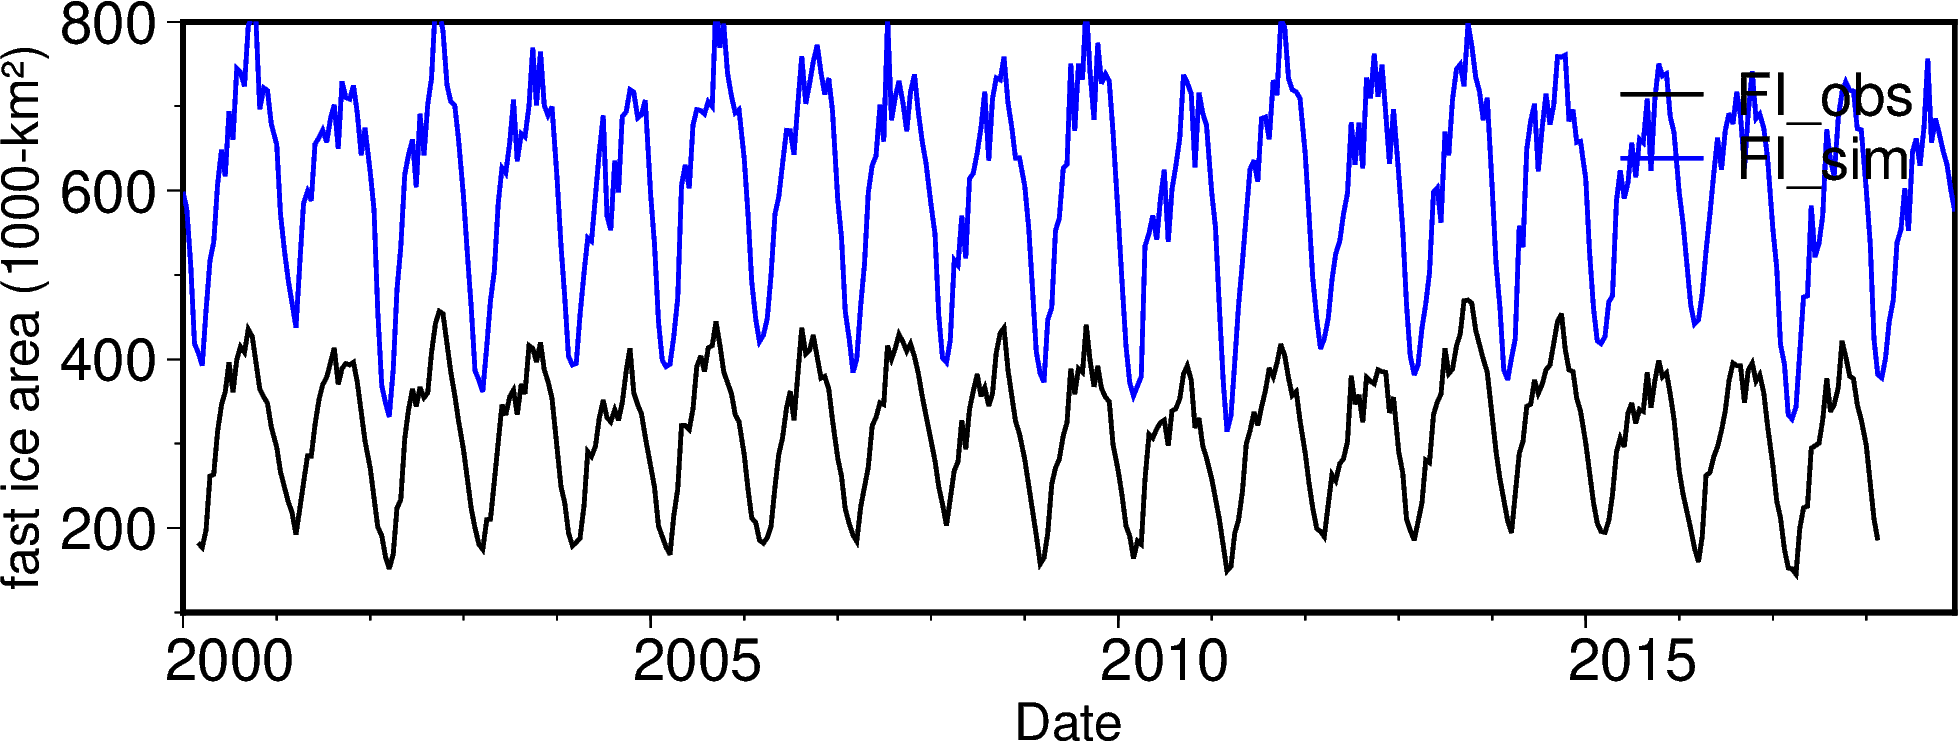

In [113]:
ts_dict = {'FI_obs' : FIA_obs, 'FI_sim': FIA_sim}
SI_tools = SeaIceToolbox(sim_name="elps-min")
SI_tools.plot_timeseries(ts_dict, ylabel="fast ice area (1000-km²)",
                        tit_str="AF2020 (obs) and elps-min (sim) after composite re-grid and binary-day filter",
                        ylim=[100,800],
                        P_png="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_and_AF2020_2000-2018_full_ts.png",
                        fig_width="15c",
                        fig_height="5c",
                        pen_styles = {"FI_obs" : "1p,black", "FI_sim" : "1p,blue"},
                        time_coord = "t_FI_obs", show_fig=True)


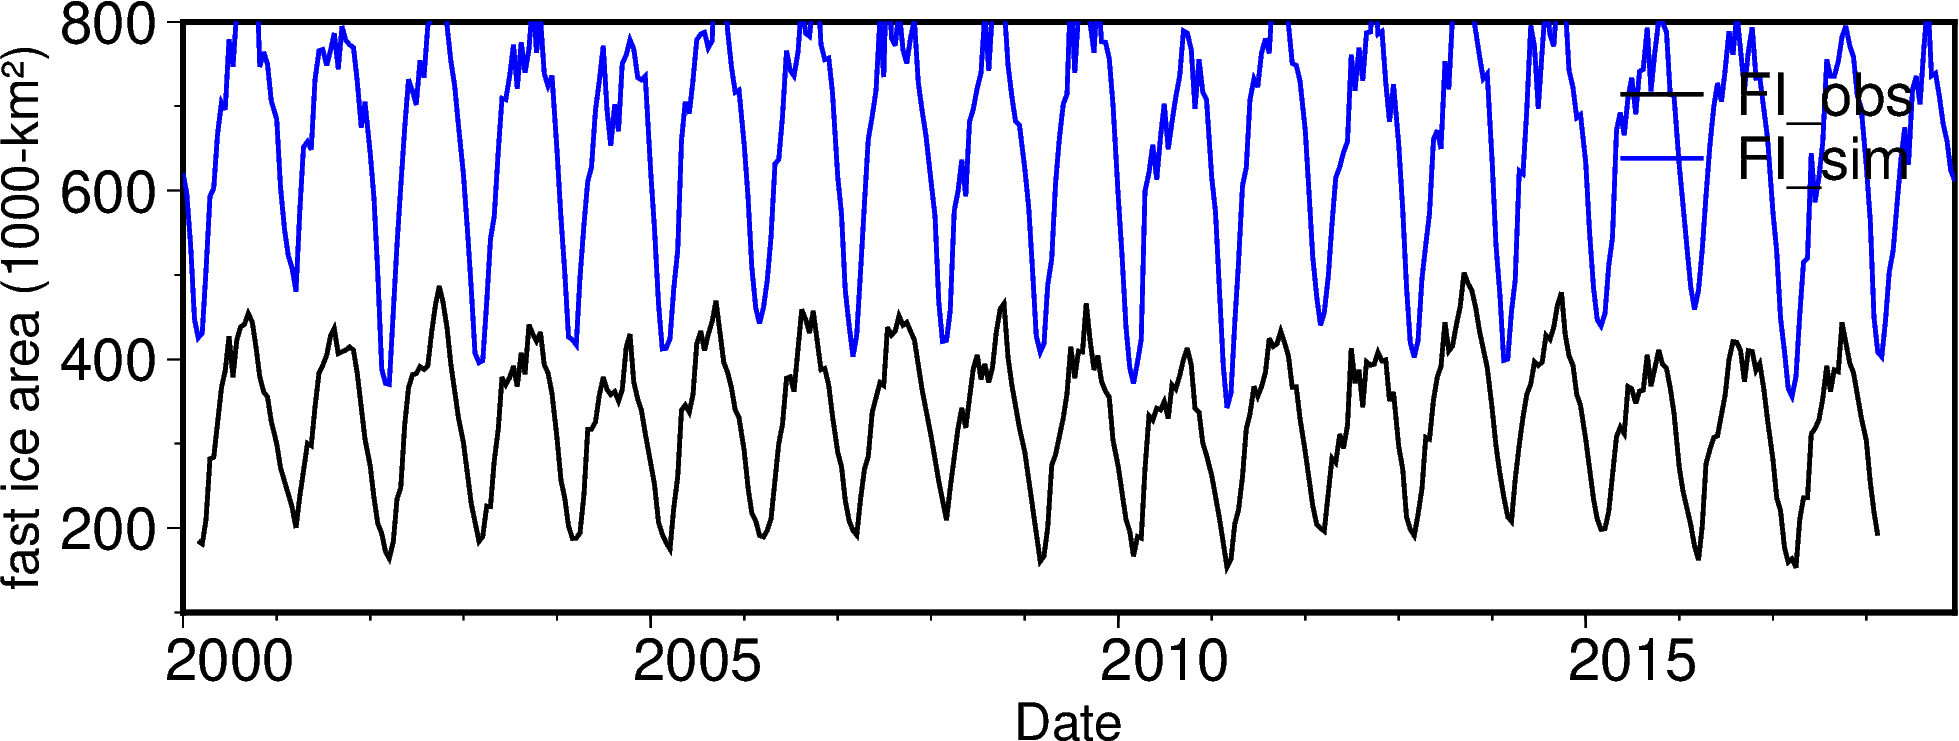

In [100]:
from IPython.display      import Image, HTML, Video
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_and_AF2020_2000-2018_full_ts.png")

In [ ]:
years = np.unique(pd.to_datetime(CICE_coar['t_FI_obs'].values).year)
for year in years:
    yearly_ds = CICE_coar.sel(t_FI_obs=str(year))
    outpath   = f"/g/data/gv90/da1339/afim_output/elps-min/FI-sim-TS_elps-min_{year}.nc"
    encoding  = {var: {"zlib": True} for var in yearly_ds.data_vars}
    yearly_ds.to_netcdf(path=outpath, mode="w", format="NETCDF4", unlimited_dims=["t_FI_obs"], encoding=encoding,)
    print(f"✅ Saved: {outpath}")

In [ ]:
sim_name = "elps-min"
dt0_str  = "2000-01-01"
dtN_str  = "2018-12-31"
years    = range(2000, 2019)
SI_tools = SeaIceToolbox(sim_name             = sim_name,
                        client               = None,
                        dt0_str              = dt0_str,
                        dtN_str              = dtN_str,
                        ice_speed_threshold  = 5e-4,
                        ice_speed_type       = "ispd_BT",
                        ice_type             = "FI_BT",
                        overwrite_zarr       = False,
                        save_new_figs        = True,
                        show_figs            = True,
                        overwrite_saved_figs = True)

In [ ]:
CICE_coar = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/elps-min/FI-sim-TS_elps-min_*.nc")
FI_obs = SI_tools.load_AF2020db()
FI_obs_SO = FI_obs.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
FI_obs_bin = FI_obs_SO['FI'].astype(bool).where(FI_obs_SO['FI'].notnull())
FI_sim_bin = CICE_coar['FI_mask'].astype(bool).where(CICE_coar['FI_mask']==1)#FI_obs_SO['FI'].notnull())
FI_obs_bin, FI_sim_bin = xr.align(FI_obs_bin, FI_sim_bin, join="inner")
FI_diff = xr.full_like(FI_obs_bin, np.nan, dtype=float)
only_obs = (FI_obs_bin == True) & (FI_sim_bin != True)
only_sim = (FI_sim_bin == True) & (FI_obs_bin != True)
agree    = (FI_obs_bin == FI_sim_bin)
FI_diff = xr.where(only_obs,     2, FI_diff)  # observation-only
FI_diff = xr.where(only_sim,     1, FI_diff)  # simulation-only
FI_diff = xr.where(agree,        0, FI_diff)  # agreement
FI_diff.name = "FI_diff"
FI_diff_computed = FI_diff.chunk({"t_FI_obs": 13, "nj": 540, "ni": 1440}).compute()
FI_diff_computed.to_netcdf(f"/g/data/gv90/da1339/afim_output/elps-min/FI-diff_obs-elps-min_2000-2018.nc")

In [ ]:
#for i in range(len(FI_diff_computed.t_FI_obs)):
i=10
dt  = pd.Timestamp(FI_diff.isel(t_FI_obs=i)['t_FI_obs'].values)
dt_str = f"{dt:%Y-%m-%d}"
SI_tools.pygmt_map_plot_one_var(FI_diff_computed.isel(t_FI_obs=i), 'FI_diff',
                            plot_regions   = 8,
                            time_stamp     = dt_str,
                            tit_str        = dt_str,
                            plot_GI        = True,
                            cbar_label     = "fast ice observation and simulation locations",
                            cbar_units     = "",
                            extend_cbar    = False,
                            lon_coord_name = "TLON",
                            lat_coord_name = "TLAT",
                            var_sq_size    = 0.125,
                            GI_sq_size     = 0.075,
                            GI_fill_color  = "yellow")

In [ ]:
P_FI_diff = Path("/g/data/gv90/da1339/afim_output/elps-min/FI-diff_obs-elps-min_2000-2018.nc")
P_FI_diff.exists()

In [ ]:
#SI_tools.compute_grounded_iceberg_area()
sims        = ["elps-min", "gi-nil", "AOM2-ERA5", "FI-heavy", "Roth-cf-def", "re-evp-off", "ndte-max", "ndte-min", "ktens-ext", "elps-ext", "elps-max"]
regions     = ["north", "south"]
var_names   = ["aice", "hi", "dvidtd", "dvidtt"]
video_paths = {sim: {region: {} for region in regions} for sim in sims}
dt0_str     = "1999-01-01"
dtN_str     = "1999-12-31"
# # STEP 1: Generate PNG frames
# for sim_name in sims:
#     for var_name in var_names:
SI_tools = SeaIceToolbox(sim_name             = sim_name,
                         dt0_str              = dt0_str,
                         dtN_str              = dtN_str,
                         P_log                = f"/g/data/gv90/da1339/logs/SeaIceToolBox_{sims[0]}_{var_names[0]}_plotting.log",
                         save_new_figs        = True,
                         show_figs            = True,
                         overwrite_saved_figs = True)
CICE_all   = SI_tools.load_iceh_zarr()
CICE_slice = CICE_all.sel(time=slice(dt0_str,dtN_str))
#        for i,dt in enumerate(CICE_slice['time'].values):

In [ ]:
#FI_sim = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-min/FI-sim-TS_elps-min_*.nc")#zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr", engine="zarr")
FI_sim = xr.open_zarr("/g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4/cice_daily_1996-09.zarr", group="FI_BT")

In [ ]:
FI_sim['FI_mask'].isel(time=10,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))

FI_sim['aice'].isel(time=10,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))
FI_sim['ispd_BT'].isel(time=10,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))

In [ ]:
FI_sim['FI_mask'].isel(t_FI_obs=18+4,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))

In [ ]:
da_FI_sim = FI_sim['FI_mask'].isel(t_FI_obs=18+4,nj=slice(25,75),ni=slice(300,400))
da_FI_obs = FI_obs.FI.isel(t_FI_obs=18,nj=slice(25,75),ni=slice(300,400))
da_FI_diff = da_FI_obs - da_FI_sim
da_FI_diff.plot(figsize=(10,10))

In [ ]:

FI_obs = xr.open_dataset("/g/data/gv90/da1339/SeaIce/FI_obs/AF-FI-2020db_org-timestep_reG.zarr", engine="zarr")
FI_obs.FI.isel(t_FI_obs=18,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))
#print(FI_sim['FIP'])
#print(FI_obs)
#FI_obs_FIP = FI_obs.FI.sum(dim="t_FI_obs") / len(FI_obs.t_FI_obs)
#print(FI_obs_FIP)
#FI_ttl_mean_diff = ds.FI_diff.sum(dim='t_FI_obs') / len(ds.t_FI_obs)
#FI_ttl_mean_diff

In [ ]:
FIP_diff = FI_obs_FIP.isel(nj=slice(0,540)) - FI_sim['FIP']
FIP_diff

In [ ]:
ds_slice = FI_sim.sel(time="2008-12-23")#,nj=SI_tools.hemisphere_dict['nj_slice'])
# plt_da   = ds_slice[var_names[0]]
# dt       = pd.Timestamp(plt_da.time.values)
# dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
SI_tools.pygmt_map_plot_one_var(ds_slice, 'aice',
                                plot_regions  = 2,
                                time_stamp    = "2008-12-23",
                                tit_str       = "2008-12-23",
                                lon_coord_name = 'lon',
                                lat_coord_name = 'lat',
                                plot_GI        = True,
                                    cbar_label     = "fast ice concentration",
                                    cbar_units     = "1/100",
                                    var_sq_size    = 0.05,
                                show_fig      = True)

In [ ]:
af2020_df                = pd.read_csv(SI_tools.AF_FI_dict['P_AF2020_cli_csv'])
FIA_dict["AF2020db_cli"] = SI_tools.interpolate_obs_fia(af2020_df)
ice_types                = [ice_type, f"{ice_type}_roll", f"{ice_type}_bool"]

In [ ]:
for i_type in ice_types:
    P_METS = Path(SI_tools.D_metrics, f"{i_type}_mets.zarr")
    P_sum  = Path(SI_tools.D_metrics, f"{i_type}_summary.csv")
    if P_METS.exists() and not SI_tools.overwrite_zarr_group:
        print(f"{P_METS} exists and not overwriting--loading")
        METS             = xr.open_zarr(P_METS)
        FIA_dict[i_type] = METS['FIA']
    else:
        print(f"{P_METS} does NOT exists and/or overwriting--computing")
        roll        = i_type.endswith("_roll")
        DS, CICE_SO = SI_tools.load_processed_cice(ice_type    = ice_type,
                                                  zarr_CICE   = True,
                                                  rolling     = roll,
                                                  slice_hem   = True)
        if i_type==f"{ice_type}_bool":
            bool_mask          = SI_tools.boolean_fast_ice(DS['FI_mask'], dim="time", window=7, min_count=6)
            DS_bool            = CICE_SO.where(bool_mask)
            DS_bool["FI_mask"] = DS["FI_mask"]
            DS                 = DS_bool
        METS = SI_tools.compute_sea_ice_metrics(DS, sim_name, i_type, SI_tools.ispd_thresh_str, P_METS, P_sum, FIA_dict["AF2020db_cli"])
    FIA_dict[i_type] = METS['FIA']

In [ ]:
FIA_dict

In [ ]:
P_png = Path(SI_tools.D_graph, sim_name, f"FIA_FIP_{sim_name}_{dt_rng_str}.png")
SI_tools.plot_FIA_FIP_faceted(FIA_dict, METS['FIP'], P_png=P_png, plot_GI=True)

In [ ]:
#SI_tools.correct_timestamp_for_all_monthly_zarr_iceh(sim_names=)
for sim in ["Cstar-min","eap-FI","elps-max","elps-min","gi-max","gi-min","gi-nil-def",
            "ktens-ext","ktens-min","ndte-max","Pstar-max","re-evp-off","Roth-cf-max","ry93",
            "Cstar-max","eap-def","elps-ext","elps-mid","FI-heavy","gi-mid","gi-nil","ktens-max",
            "ktens-nil","ndte-min","Pstar-min","Roth-cf-def","Roth-cf-min","visc-meth"]:
    SI_tools = SeaIceToolbox(sim_name             = sim,
                             dt0_str              = dt0_str,
                             dtN_str              = "2023-12-31",
                             ice_speed_threshold  = 5e-4,
                             ice_speed_type       = "ispd_BT",
                             ice_type             = "FI_BT",
                             overwrite_zarr       = False,
                             save_new_figs        = True,
                             show_figs            = True,
                             overwrite_saved_figs = True)
    SI_tools.daily_iceh_to_monthly_zarr(overwrite=False, delete_original=True)

In [ ]:
var_name = "hi"

In [ ]:
DS, CICE            = SI_tools.load_processed_cice(ispd_thresh = 5e-4,
                                                   ice_type    = "FI_BT",
                                                   zarr_CICE   = True,
                                                   rolling     = False,
                                                   slice_hem   = False)

In [ ]:
CICE_ispds          = SI_tools.compute_ice_speed_types( CICE , ['ispd_BT'] )
CICE_reM            = SI_tools.reapply_landmask( CICE_ispds )
CICE_reM['ispd_BT'] = SI_tools.compute_composite_ice_speed( CICE_reM )

In [ ]:
CICE_reM

In [ ]:
ds_slice = CICE_reM.isel(time=2400, nj=SI_proc.hemisphere_dict['nj_slice'])
plt_da   = ds_slice[var_name]
SIA = SI_proc.compute_ice_area( ds_slice['aice'] , ds_slice['tarea'] , ice_area_scale=SI_proc.SIC_scale )
SIA.values

In [ ]:
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
dt_rng_str = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type   = "FI_BT"
SIA_dict   = {}
FIA_dict   = {}
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           ice_speed_threshold  = 5e-4,
                           ice_speed_type       = "ispd_BT",
                           ice_type             = "FI_BT",
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
CICE_all            = SI_tools.load_iceh_zarr()
CICE_ispds          = SI_tools.compute_ice_speed_types( CICE_all, ['ispd_BT'] )
CICE_reM            = SI_tools.reapply_landmask( CICE_ispds )
CICE_reM['ispd_BT'] = SI_tools.compute_composite_ice_speed( CICE_reM )
for i in np.arange(2400,2500,1):
    ds_slice = CICE_reM.isel(time=i, nj=SI_tools.hemisphere_dict['nj_slice'])
    plt_da   = ds_slice['ispd_BT']
    dt       = pd.Timestamp( plt_da.time.values )
    dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    SI_tools.pygmt_map_plot_one_var(plt_da, 'ispd_BT',
                                    plot_regions  = 8,
                                    time_stamp    = dt_str,
                                    tit_str       = dt_str,
                                    plot_GI       = True,
                                    var_sq_size   = 0.2,
                                    series        = (0,.5),
                                    GI_fill_color = 'red', 
                                    GI_sq_size    = 0.075,
                                    extend_cbar   = True,
                                    show_fig      = False)

In [ ]:
#sim_names       = SI_proc.config.get('sim_dict').keys()
#SI_proc.correct_timestamp_for_all_monthly_zarr_iceh( sim_names=sim_names, dry_run=False )
SI_proc.daily_iceh_to_monthly_zarr(overwrite=overwrite_zarr, delete_original=delete_original)
NSIDC             = SI_proc.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = NSIDC['SIA']
# if daily:
#     DS_daily = SI_proc.process_daily_cice(ispd_type            = ispd_types,
#                                           overwrite_zarr_group = overwrite_zarr)
# if rolling:
#     DS_roll = SI_proc.process_rolling_cice(mean_period          = roll_period,
#                                            ispd_type            = ispd_types,
#                                            overwrite_zarr_group = overwrite_zarr)
DS, CICE_SO       = SI_proc.load_processed_cice(ispd_thresh = ispd_thresh,
                                          ice_type    = ice_types[0],
                                          zarr_CICE   = True,
                                          rolling     = True if ice_types[0]==f"{ice_types[0]}_roll" else False,
                                          slice_hem   = True)
SIA_dict[sim_name] = SI_proc.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_proc.SIC_scale)
SI_plot.plot_monthly_ice_area_by_year(SIA_dict,
                                      ice_type = "SI",
                                      tit_str  = tit_str,
                                      P_png    = P_png,
                                      ylim     = (1,20))

In [ ]:
SI_proc.sim_config

In [ ]:
#FIA_dict[sim_name]       = SI_proc.compute_ice_area(DS['aice'], DS['tarea']).compute()
#tit_str = f"Fast Ice Area Southern Ocean, {dt_rng_str}, AF2020db Climatology and Station Names: {sim_name}"
ktens    = SI_proc.sim_config['Ktens']
elps     = SI_proc.sim_config['e_yieldcurve']
ndte     = SI_proc.sim_config['ndte']
Cf       = SI_proc.sim_config['Cf']
GI_thin  = 1 - SI_proc.sim_config['GI_thin_fact']
#Pstar = float(SI_proc.sim_config['Pstar'].replace("D", "E"))
tit_str  = f"simulation name: {sim_name}\ntested CICE namelist parameter: Rothrock Strength Formulation; Cf={Cf}, ktens={ktens}, e={elps}, GI-concentration={GI_thin:0.2f};"
P_png    = Path(SI_plot.D_graph, "timeseries", f"FIA_AF2020db_and_{sim_name}_{dt_rng_str}.png")
SI_plot.plot_monthly_ice_area_by_year(FIA_dict,
                                      ice_type = "FI",
                                      tit_str  = tit_str,
                                      P_png    = P_png)